# 0. Ready for Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

 99% 6.22G/6.31G [00:18<00:00, 698MB/s]
100% 6.31G/6.31G [00:18<00:00, 366MB/s]


In [ ]:
!unzip histopathologic-cancer-detection.zip -d /content/histopathologic-cancer/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/histopathologic-cancer/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: /content/histopathologic-cancer/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: /content/histopathologic-cancer/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: /content/histopathologic-cancer/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: /content/histopathologic-cancer/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: /content/histopathologic-cancer/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: /content/histopathologic-cancer/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: /content/histopathologic-cancer/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: /content/histopathologic-cancer/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: /content/histopathologic-cancer/train/fa2e80e84594465329bdc0c8d1b3a50

# 1. Problem & Data

## 1-1. Problem Definition

- This is a binary image classification problem.

- The main goal is to look at a small image and check if it has cancer. We will design a model that classifies 96x96 pixel image patches. If the center part of the image has tumor tissue, the label is 1. If not, the label is 0.

## 1-2. Data Explanation

* Train Data : 220,025 images (The labels are in train_labels.csv).
* Test Data : 57,458 images
  * Image Details :
   *  All images are 96x96 pixels.
   *  They are color images (3 channels, RGB).
   * The file format is TIF.
* Class Distribution : About 40% of images are 1(cancer), and 60% are 0(normal).

# 2. EDA

* Exploratory Data Analysis (EDA) is the process of intuitively understanding the data and identifying its characteristics before modeling. This step involves checking the basic information of the data, analyzing the distribution of labels, visualizing sample images, examining for duplicate data, and detecting outliers or abnormal data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import hashlib
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
nature_colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

In [ ]:
BASE_PATH = '/content/histopathologic-cancer/'
TRAIN_IMG_PATH = os.path.join(BASE_PATH, 'train/')

In [ ]:
df_labels = pd.read_csv(os.path.join(BASE_PATH, 'train_labels.csv'))

In [ ]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
df_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

## 2-1. Label Distribution Analysis

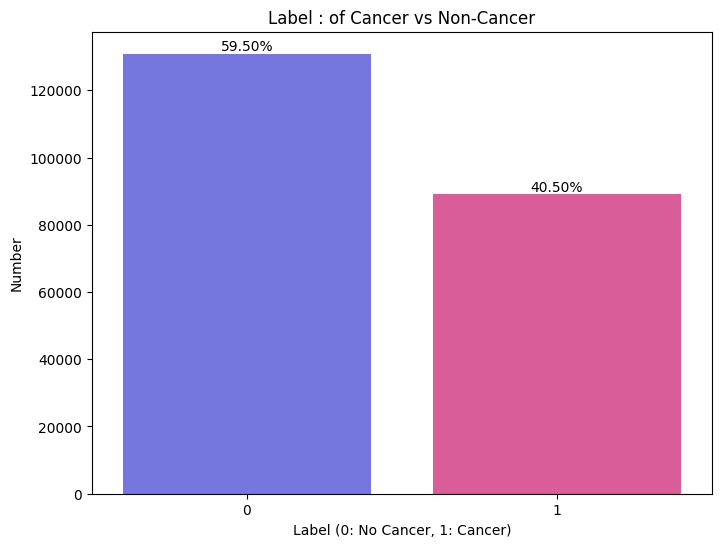

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_labels, x='label', hue='label',
                   palette=['#6366F1', '#EC4899'], legend=False)
plt.title('Label : of Cancer vs Non-Cancer')
plt.xlabel('Label (0: No Cancer, 1: Cancer)')
plt.ylabel('Number')

total = len(df_labels)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

## 2-2. Sample Image Visualization

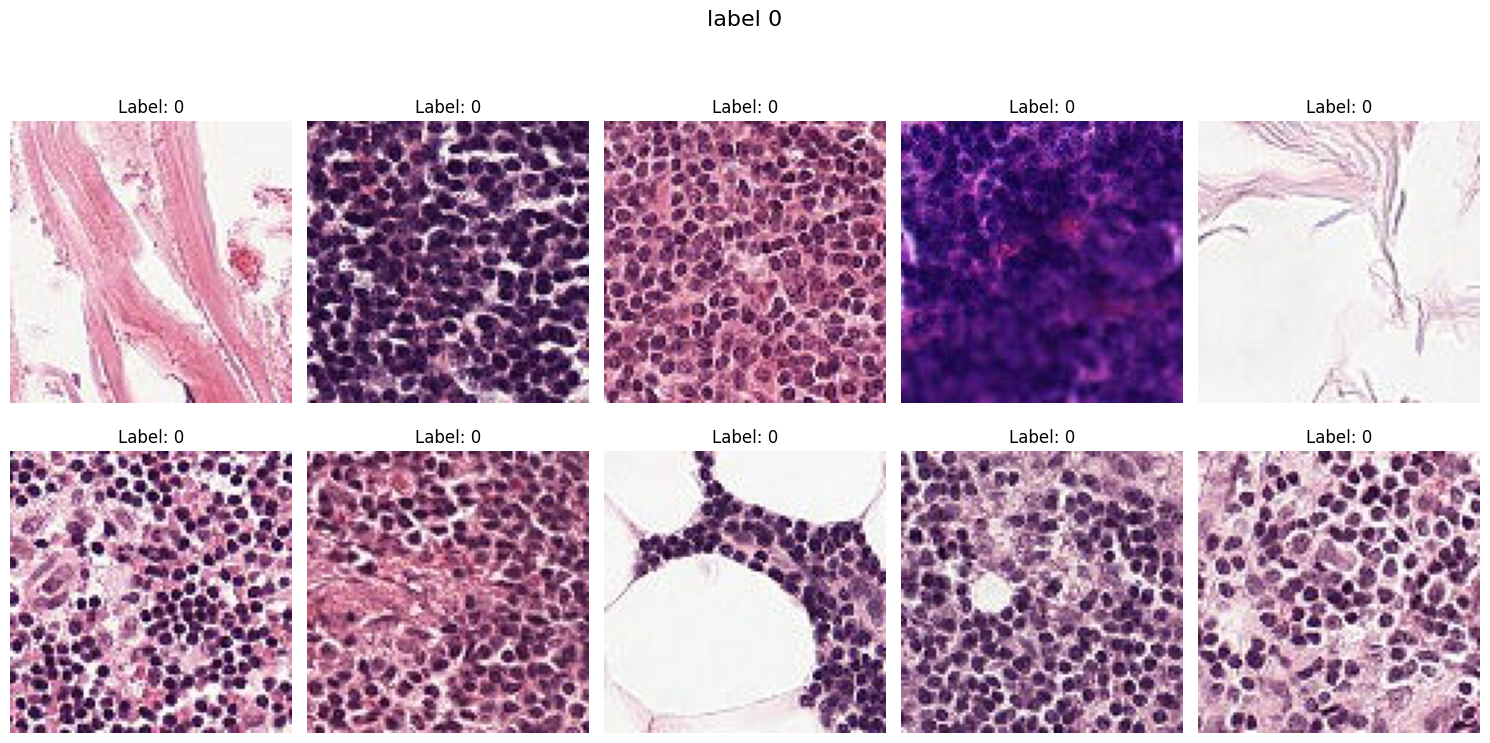

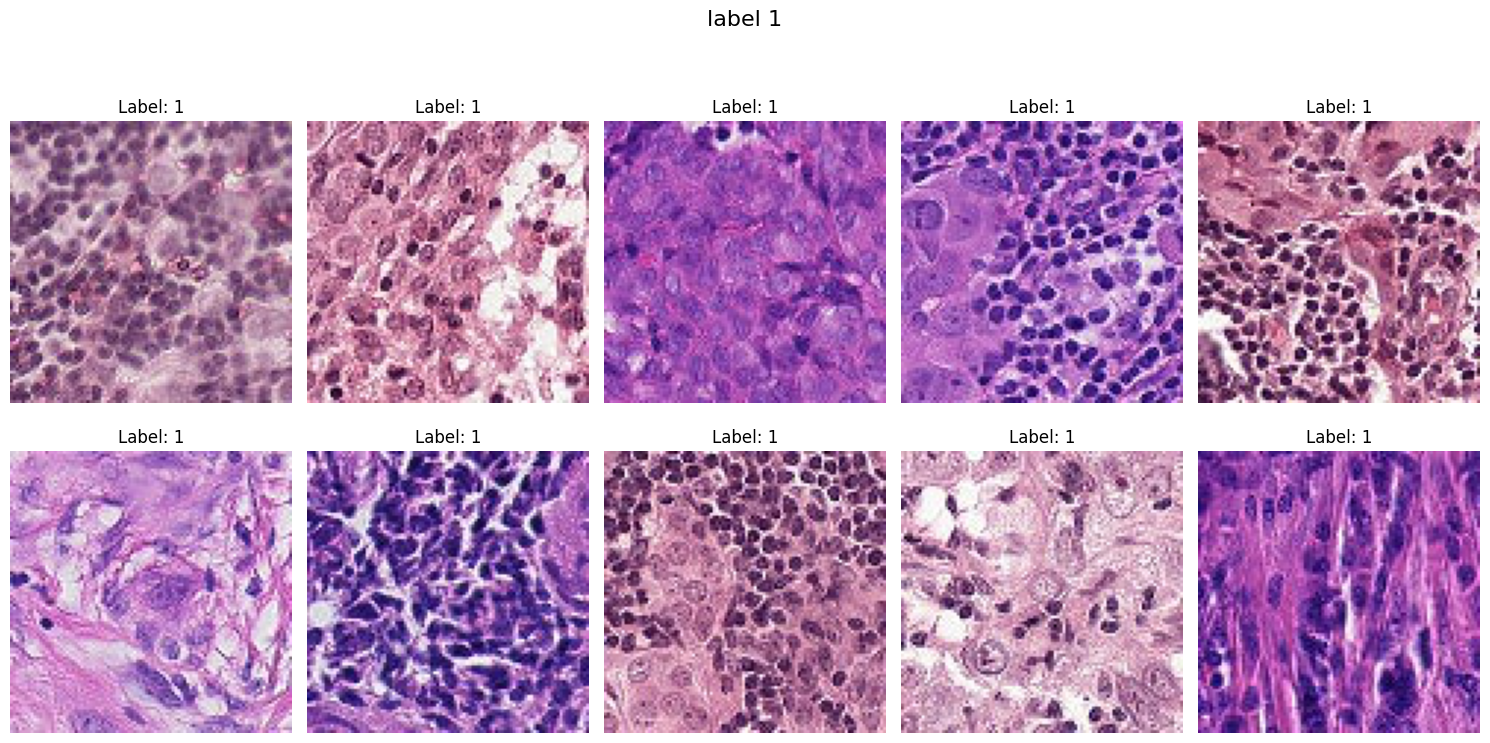

In [ ]:
def show_sample_images(label, num_images=10, title="Sample Images"):
    plt.figure(figsize=(15, 8))

    sample_df = df_labels[df_labels['label'] == label].sample(num_images, random_state=42)
    image_ids = sample_df['id'].tolist()

    for i, image_id in enumerate(image_ids):
        image_path = os.path.join(TRAIN_IMG_PATH, f'{image_id}.tif')
        img = Image.open(image_path)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_sample_images(label=0, num_images=10, title="label 0")
show_sample_images(label=1, num_images=10, title="label 1")

## 2-3. Duplicate Data Check

In [52]:
duplicate_ids = df_labels[df_labels.duplicated(subset=['id'], keep=False)]
print(f"Number of duplicate image IDs: {len(duplicate_ids)}")

if len(duplicate_ids) > 0:
    print("\nDuplicate IDs found:")
    print(duplicate_ids.head())

def get_image_hash(image_path):
    try:
        img = cv2.imread(image_path)
        return hashlib.md5(img.tobytes()).hexdigest()
    except:
        return None

sample_size = 5000
sample_df = df_labels.sample(n=sample_size, random_state=42)

image_hashes = {}
duplicate_images = []

for idx, row in tqdm(sample_df.iterrows(), total=sample_size, desc="Hashing images"):
    image_id = row['id']
    image_path = os.path.join(TRAIN_IMG_PATH, f'{image_id}.tif')

    hash_value = get_image_hash(image_path)
    if hash_value:
        if hash_value in image_hashes:
            duplicate_images.append((image_id, image_hashes[hash_value]))
        else:
            image_hashes[hash_value] = image_id

print(f"Number of duplicate images found in sample: {len(duplicate_images)}")
if duplicate_images:
    print("Examples of duplicate images:", duplicate_images[:5])

Number of duplicate image IDs: 0


Hashing images: 100%|██████████| 5000/5000 [00:01<00:00, 3871.87it/s]

Number of duplicate images found in sample: 0


## 2-4. Outlier and Anomaly Detection

Analyzing images: 100%|██████████| 1000/1000 [00:00<00:00, 2366.84it/s]



Image dimensions:
Unique widths: {96}
Unique heights: {96}
Unique channels: {3}


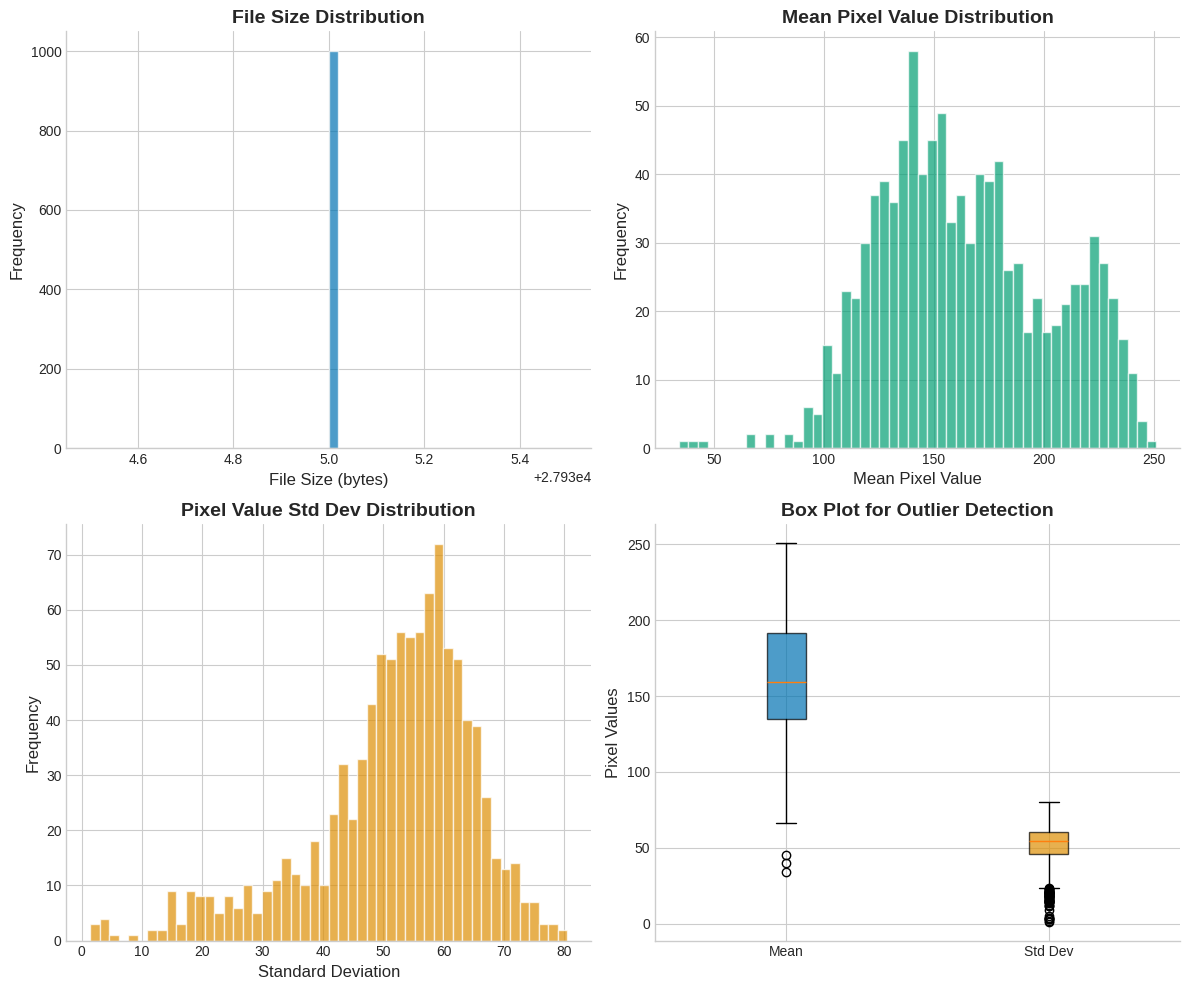

Mean pixel values - Mean: 164.00, Std: 38.53
Std dev values - Mean: 51.66, Std: 13.62
File sizes - Mean: 27.28 KB, Std: 0.00 KB


In [51]:
def analyze_image_properties(sample_size=1000):

    sample_df = df_labels.sample(n=sample_size, random_state=42)

    widths = []
    heights = []
    channels = []
    file_sizes = []
    mean_pixels = []
    std_pixels = []

    for idx, row in tqdm(sample_df.iterrows(), total=sample_size, desc="Analyzing images"):
        image_id = row['id']
        image_path = os.path.join(TRAIN_IMG_PATH, f'{image_id}.tif')

        try:
            file_size = os.path.getsize(image_path)
            file_sizes.append(file_size)

            img = cv2.imread(image_path)

            if img is not None:
                height, width, channel = img.shape
                widths.append(width)
                heights.append(height)
                channels.append(channel)

                mean_pixels.append(np.mean(img))
                std_pixels.append(np.std(img))

        except Exception as e:
            print(f"Error processing {image_id}: {e}")

    return {
        'widths': widths,
        'heights': heights,
        'channels': channels,
        'file_sizes': file_sizes,
        'mean_pixels': mean_pixels,
        'std_pixels': std_pixels
    }

img_props = analyze_image_properties(sample_size=1000)

print(f"\nImage dimensions:")
print(f"Unique widths: {set(img_props['widths'])}")
print(f"Unique heights: {set(img_props['heights'])}")
print(f"Unique channels: {set(img_props['channels'])}")

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(img_props['file_sizes'], bins=50, color=nature_colors[0], alpha=0.7, edgecolor='white')
axes[0, 0].set_title('File Size Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('File Size (bytes)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)

axes[0, 1].hist(img_props['mean_pixels'], bins=50, color=nature_colors[2], alpha=0.7, edgecolor='white')
axes[0, 1].set_title('Mean Pixel Value Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mean Pixel Value', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)

axes[1, 0].hist(img_props['std_pixels'], bins=50, color=nature_colors[1], alpha=0.7, edgecolor='white')
axes[1, 0].set_title('Pixel Value Std Dev Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Standard Deviation', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)

bp = axes[1, 1].boxplot([img_props['mean_pixels'], img_props['std_pixels']],
                        labels=['Mean', 'Std Dev'],
                        patch_artist=True)

for patch, color in zip(bp['boxes'], [nature_colors[0], nature_colors[1]]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 1].set_title('Box Plot for Outlier Detection', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Pixel Values', fontsize=12)

for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Pixel Statistics Summary
print(f"Mean pixel values - Mean: {np.mean(img_props['mean_pixels']):.2f}, Std: {np.std(img_props['mean_pixels']):.2f}")
print(f"Std dev values - Mean: {np.mean(img_props['std_pixels']):.2f}, Std: {np.std(img_props['std_pixels']):.2f}")
print(f"File sizes - Mean: {np.mean(img_props['file_sizes'])/1024:.2f} KB, Std: {np.std(img_props['file_sizes'])/1024:.2f} KB")

## 2-5. Data Split for Training, Validation and Testing

In [ ]:
X = df_labels['id'].values
y = df_labels['label'].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# train, valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 ≈ 0.15/0.85
)

In [ ]:
print(f"Train : {len(X_train)} samples ({len(X_train)/len(df_labels)*100:.1f}%)")
print(f"Valid : {len(X_valid)} samples ({len(X_valid)/len(df_labels)*100:.1f}%)")
print(f"Test : {len(X_test)} samples ({len(X_test)/len(df_labels)*100:.1f}%)")

Train : 154105 samples (70.0%)
Valid : 32916 samples (15.0%)
Test : 33004 samples (15.0%)


In [ ]:
# DataFrame
train_df = pd.DataFrame({'id': X_train, 'label': y_train})
valid_df = pd.DataFrame({'id': X_valid, 'label': y_valid})
test_df = pd.DataFrame({'id': X_test, 'label': y_test})

# save to csv
train_df.to_csv('train_split.csv', index=False)
valid_df.to_csv('valid_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

# 3. Architecture

* <mark>Rationale for Model T</mark>

 * Inspired by the architectural philosophy of VGGNet, I custom-designed a CNN model. To effectively extract detailed features from 96x96 images, I stacked multiple 3x3 filters. To prevent overfitting and ensure stable training, Batch Normalization and Dropout were added to each convolutional block.
  
* <mark> Rationale for Transfer Learning Models </Mark>

 * Models pre-trained on ImageNet have already learned universal image features. Therefore, I determined that high performance could be expected even with a small dataset. I selected ResNet50 and EfficientNetB0 with the expectation that they would effectively capture the fine-grained and detailed characteristics typical of medical images. Furthermore, MobileNetV2 was included to explore the extent to which the model could be made more lightweight.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 0.001

In [ ]:
model_t = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
], name='Model_T')

In [ ]:
model_t.summary()

Model: "Model_T"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,425 (497.75 KB)

 Trainable params: 126,977 (496.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_resnet.trainable = False

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
], name='ResNet50')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [ ]:
base_efficient = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_efficient.trainable = False

efficient_model = models.Sequential([
    base_efficient,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
], name='EfficientNetB0')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficient_model.summary()

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,788 (16.70 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [ ]:
base_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_mobile.trainable = False

mobile_model = models.Sequential([
    base_mobile,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
], name='MobileNetV2')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobile_model.summary()

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [ ]:
model_dict = {
    'Model_T': model_t,
    'ResNet50': resnet_model,
    'EfficientNetB0': efficient_model,
    'MobileNetV2': mobile_model
}

## 3-1. Model Compile

* All models are compiled with the same configuration for fair comparison :

 * Optimizer : Adam with lr 0.001

 * Loss : Binary Crossentropy with Label Smoothing 0.1 to prevent overconfidence

 * Metrics : Accuracy, AUC, Precision, Recall

In [ ]:
def compile_model(model):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=['accuracy',
                keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
for name, model in model_dict.items():
    model_dict[name] = compile_model(model)

## 3-2. Data Preparation and Augmentation

* We us Data Augmentation to increase the diversity of Train Dataset.

 * Rotation up to 90 degress

 * Width and height shifts

 * Horizontal and vertical flips

 * Zoom

 * Reflect mode for filling

In [ ]:
train_df = pd.read_csv('train_split.csv')
valid_df = pd.read_csv('valid_split.csv')
test_df = pd.read_csv('test_split.csv')

train_df['id'] = train_df['id'].astype(str) + '.tif'
valid_df['id'] = valid_df['id'].astype(str) + '.tif'
test_df['id'] = test_df['id'].astype(str) + '.tif'

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [ ]:
# Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='reflect'
)

# Val
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=TRAIN_IMG_PATH,
    x_col='id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    valid_df,
    directory=TRAIN_IMG_PATH,
    x_col='id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory=TRAIN_IMG_PATH,
    x_col='id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 154105 validated image filenames belonging to 2 classes.
Found 32916 validated image filenames belonging to 2 classes.
Found 33004 validated image filenames belonging to 2 classes.


## 3-3. Callbacks

* We use callbacks to improve training :

 * EarlyStopping : Stops training when validation loss doesn't improve

 * ReduceLROnPlateau : Reduces learning rate when stuck

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

## 3-4. Training

- Training all four models with the same configuration

In [ ]:
model_t_history = model_t.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.8061 - auc: 0.8693 - loss: 0.4996 - precision: 0.7863 - recall: 0.7156 - val_accuracy: 0.4113 - val_auc: 0.8368 - val_loss: 1.8358 - val_precision: 0.4076 - val_recall: 0.9999 - learning_rate: 0.0010
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.8618 - auc: 0.9298 - loss: 0.4182 - precision: 0.8435 - recall: 0.8078 - val_accuracy: 0.7118 - val_auc: 0.8954 - val_loss: 0.6612 - val_precision: 0.5901 - val_recall: 0.9446 - learning_rate: 0.0010
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.8826 - auc: 0.9458 - loss: 0.3906 - precision: 0.8681 - recall: 0.8371 - val_accuracy: 0.8657 - val_auc: 0.9443 - val_loss: 0.4223 - val_precision: 0.9084 - val_recall: 0.7435 - learning_rate: 0.0010
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.8942 - auc: 0.9534 - loss: 0.3760 - precision: 0.8845 - recall: 0.8503 - val_accuracy: 0.8170 - val_auc: 0.9228 - val_loss: 0.5084 -

In [ ]:
model_t_test = model_t.evaluate(test_generator)
model_t_test[0] = round(model_t_test[0], 4) # Test Loss
model_t_test[1] = round(model_t_test[1], 4) # Test Accuracy
model_t_test[2] = round(model_t_test[2], 4) # Test AUC
model_t_test[3] = round(model_t_test[3], 4) # Precision
model_t_test[4] = round(model_t_test[4], 4) # Recall

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 378ms/step - accuracy: 0.8881 - auc: 0.9521 - loss: 0.3872 - precision: 0.8798 - recall: 0.8389


In [ ]:
# ResNet50
resnet_history = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

resnet_test = resnet_model.evaluate(test_generator)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.6789 - auc: 0.7293 - loss: 0.6210 - precision: 0.6089 - recall: 0.5966 - val_accuracy: 0.4124 - val_auc: 0.7770 - val_loss: 0.7406 - val_precision: 0.4080 - val_recall: 0.9989 - learning_rate: 0.0010
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.7206 - auc: 0.7810 - loss: 0.5827 - precision: 0.6634 - recall: 0.6294 - val_accuracy: 0.6240 - val_auc: 0.7750 - val_loss: 0.6524 - val_precision: 0.5209 - val_recall: 0.8936 - learning_rate: 0.0010
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.7208 - auc: 0.7809 - loss: 0.5832 - precision: 0.6664 - recall: 0.6270 - val_accuracy: 0.7088 - val_auc: 0.7680 - val_loss: 0.6072 - val_precision: 0.6871 - val_recall: 0.5163 - learning_rate: 0.0010
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.7233 - auc: 0.7843 - loss: 0.5806 - precision: 0.6677 - recall: 0.6322 - val_accuracy: 0.5950 - val_auc: 0.7747 - val_loss: 1.2496 -

In [ ]:
# EfficientNetB0
efficient_history = efficient_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

efficient_test = efficient_model.evaluate(test_generator)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.5463 - auc: 0.5257 - loss: 0.7382 - precision: 0.4120 - recall: 0.2899 - val_accuracy: 0.5950 - val_auc: 0.5658 - val_loss: 0.6740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.5713 - auc: 0.5610 - loss: 0.6747 - precision: 0.3770 - recall: 0.0873 - val_accuracy: 0.4228 - val_auc: 0.5674 - val_loss: 0.7721 - val_precision: 0.4121 - val_recall: 0.9962 - learning_rate: 0.0010
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.5699 - auc: 0.5717 - loss: 0.6707 - precision: 0.3546 - recall: 0.0748 - val_accuracy: 0.5418 - val_auc: 0.5713 - val_loss: 0.6682 - val_precision: 0.4333 - val_recall: 0.4266 - learning_rate: 0.0010
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.5653 - auc: 0.5818 - loss: 0.6689 - precision: 0.3641 - recall: 0.0920 - val_accuracy: 0.4981 - val_auc: 0.5744 - val_loss: 

In [ ]:
# MobileNetV2
mobile_history = mobile_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

mobile_test = mobile_model.evaluate(test_generator)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.7984 - auc: 0.8673 - loss: 0.5489 - precision: 0.7544 - recall: 0.7522 - val_accuracy: 0.8500 - val_auc: 0.9271 - val_loss: 0.4272 - val_precision: 0.8112 - val_recall: 0.8207 - learning_rate: 0.0010
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.8532 - auc: 0.9225 - loss: 0.4294 - precision: 0.8424 - recall: 0.7831 - val_accuracy: 0.8565 - val_auc: 0.9321 - val_loss: 0.4160 - val_precision: 0.8351 - val_recall: 0.8048 - learning_rate: 0.0010
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.8585 - auc: 0.9280 - loss: 0.4209 - precision: 0.8502 - recall: 0.7896 - val_accuracy: 0.8594 - val_auc: 0.9349 - val_loss: 0.4136 - val_precision: 0.8184 - val_recall: 0.8389 - learning_rate: 0.0010
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.8613 - auc: 0.9306 - loss: 0.4166 - precision: 0.8524 - recall: 0.7951 - val_accuracy: 0.8537 - val_auc: 0.9332 - val_loss: 0.4184 -

In [ ]:
all_histories = {
    'Model_T': model_t_history,
    'ResNet50': resnet_history,
    'EfficientNetB0': efficient_history,
    'MobileNetV2': mobile_history
}

all_test_results = {
    'Model_T': {
        'loss': model_t_test[0],
        'accuracy': model_t_test[1],
        'auc': model_t_test[2],
        'precision': model_t_test[3],
        'recall': model_t_test[4]
    },
    'ResNet50': {
        'loss': round(resnet_test[0], 4),
        'accuracy': round(resnet_test[1], 4),
        'auc': round(resnet_test[2], 4),
        'precision': round(resnet_test[3], 4),
        'recall': round(resnet_test[4], 4)
    },
    'EfficientNetB0': {
        'loss': round(efficient_test[0], 4),
        'accuracy': round(efficient_test[1], 4),
        'auc': round(efficient_test[2], 4),
        'precision': round(efficient_test[3], 4),
        'recall': round(efficient_test[4], 4)
    },
    'MobileNetV2': {
        'loss': round(mobile_test[0], 4),
        'accuracy': round(mobile_test[1], 4),
        'auc': round(mobile_test[2], 4),
        'precision': round(mobile_test[3], 4),
        'recall': round(mobile_test[4], 4)
    }
}

# 4. Results

## 4-1. Training History Visualization

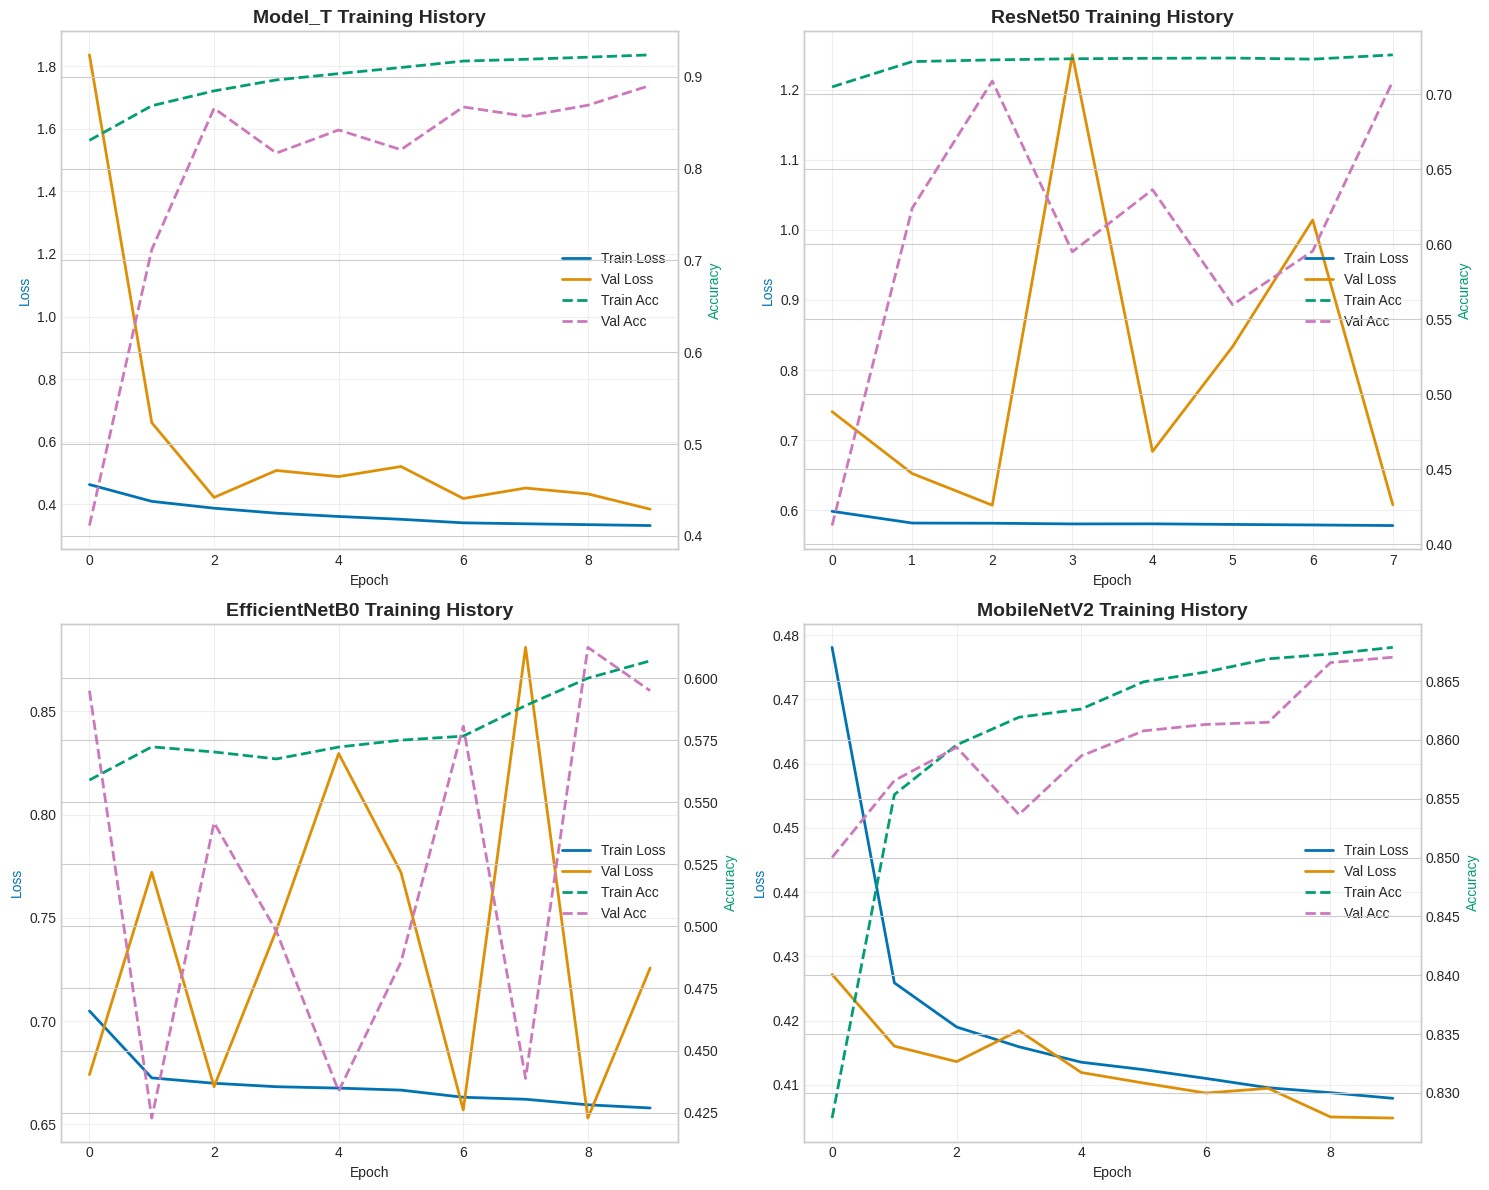

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, history) in enumerate(all_histories.items()):
    ax = axes[idx]

    # Loss
    ax.plot(history.history['loss'], label='Train Loss', color=nature_colors[0], linewidth=2)
    ax.plot(history.history['val_loss'], label='Val Loss', color=nature_colors[1], linewidth=2)

    # Accuracy
    ax2 = ax.twinx()
    ax2.plot(history.history['accuracy'], label='Train Acc', color=nature_colors[2], linewidth=2, linestyle='--')
    ax2.plot(history.history['val_accuracy'], label='Val Acc', color=nature_colors[3], linewidth=2, linestyle='--')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss', color=nature_colors[0])
    ax2.set_ylabel('Accuracy', color=nature_colors[2])
    ax.set_title(f'{name} Training History', fontsize=14, fontweight='bold')

    # Legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4-2. Model Performance Comparison


=== Model Performance Comparison ===
                  loss  accuracy     auc  precision  recall  f1_score
Model_T         0.3869    0.8880  0.9522     0.8813  0.8362    0.8582
ResNet50        0.6066    0.7103  0.7685     0.6881  0.5209    0.5929
EfficientNetB0  0.6531    0.6140  0.6191     0.7269  0.0755    0.1368
MobileNetV2     0.4071    0.8645  0.9382     0.8669  0.7862    0.8246


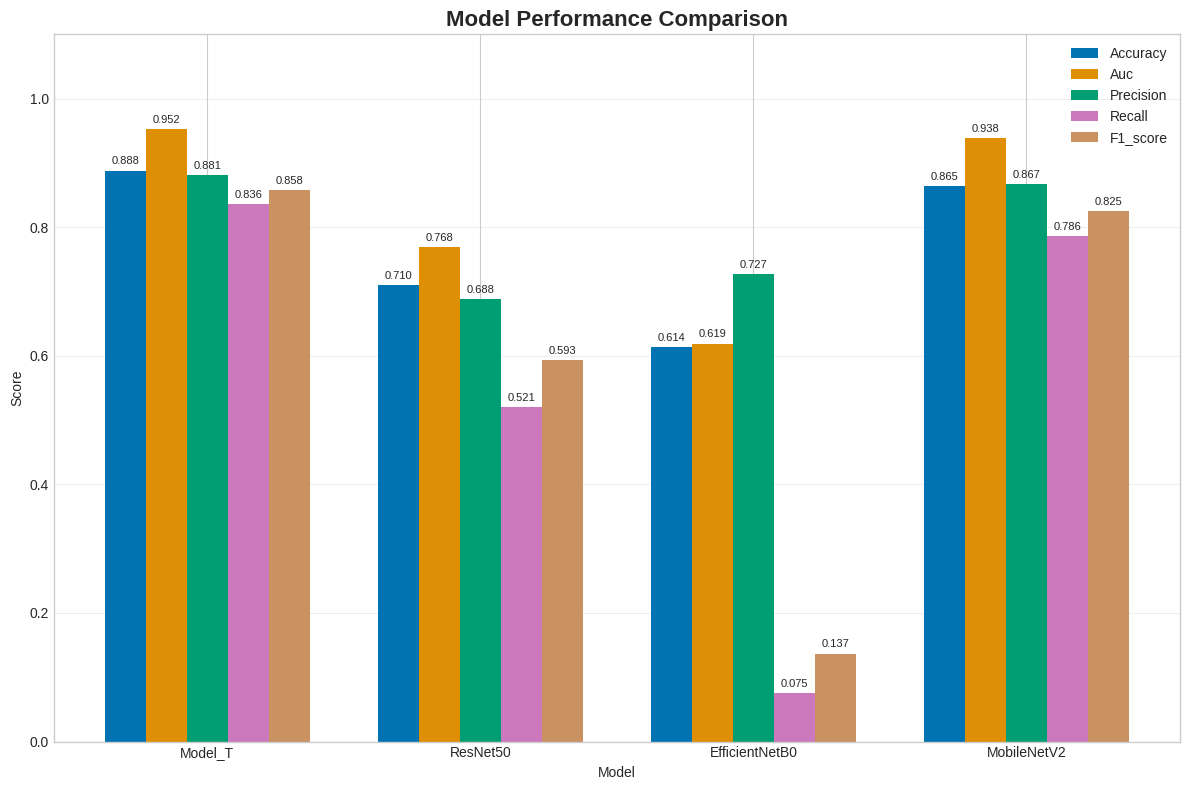

In [ ]:
results_df = pd.DataFrame(all_test_results).T
results_df = results_df.round(4)

results_df['f1_score'] = 2 * (results_df['precision'] * results_df['recall']) / (results_df['precision'] + results_df['recall'])
results_df['f1_score'] = results_df['f1_score'].round(4)

# Model Performance Comparison (table)
print(results_df)

# Model Performance Comparison (plot)
fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['accuracy', 'auc', 'precision', 'recall', 'f1_score']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    offset = (i - 2) * width
    bars = ax.bar(x + offset, results_df[metric], width,
                   label=metric.capitalize(), color=nature_colors[i])

    # 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4-3. Confusion Matrix

- Confusion matrices help us understand the types of errors each model makes.

65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 333ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 382ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 414ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 374ms/step


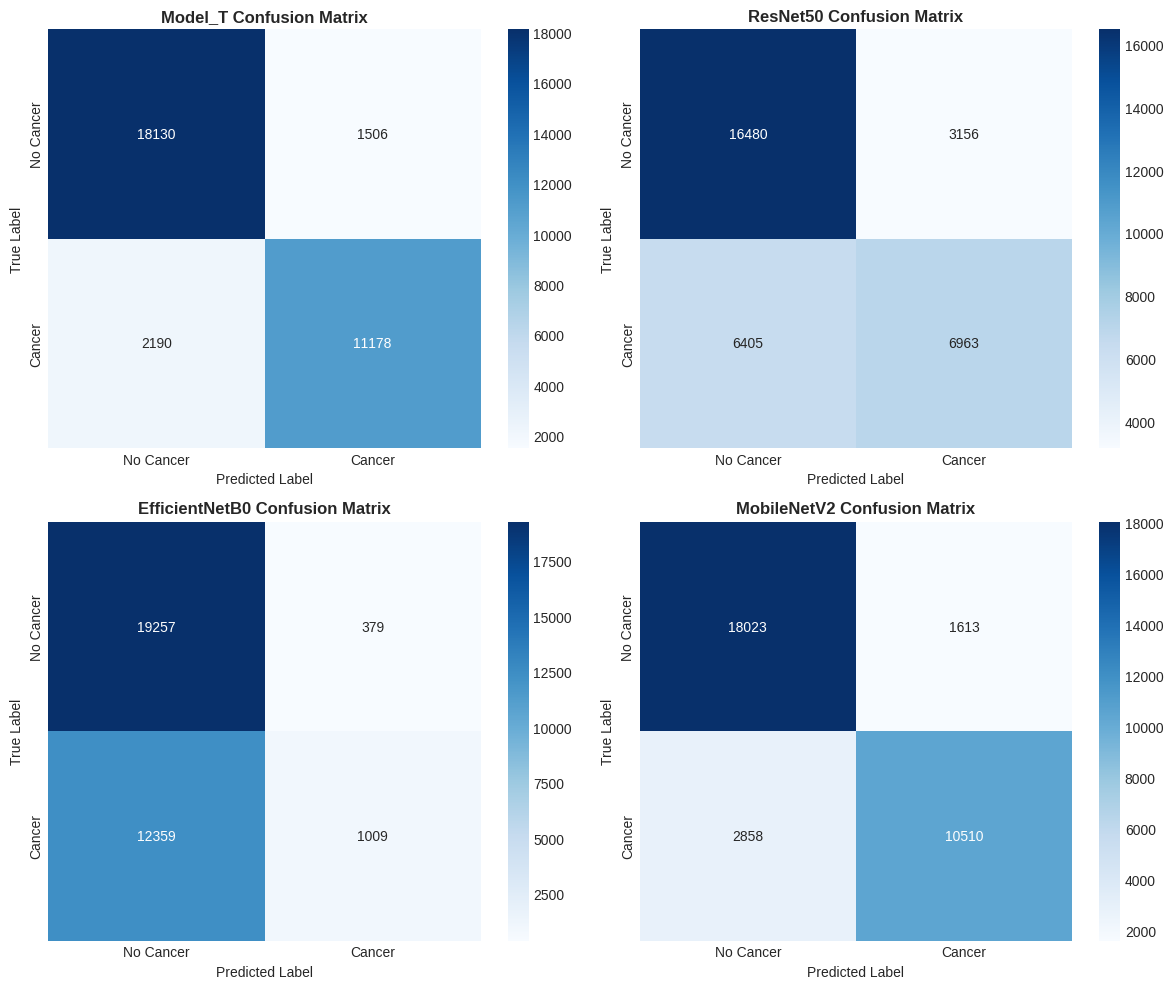

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(model_dict.items()):
    # prediction
    y_pred_proba = model.predict(test_generator)
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_true = test_generator.labels

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # visualization
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Cancer', 'Cancer'],
                yticklabels=['No Cancer', 'Cancer'],
                ax=ax)
    ax.set_title(f'{name} Confusion Matrix', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 4-4. ROC Curve Analysis

- ROC curves show the trade-off between true positive rate and false positive rate.

65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step


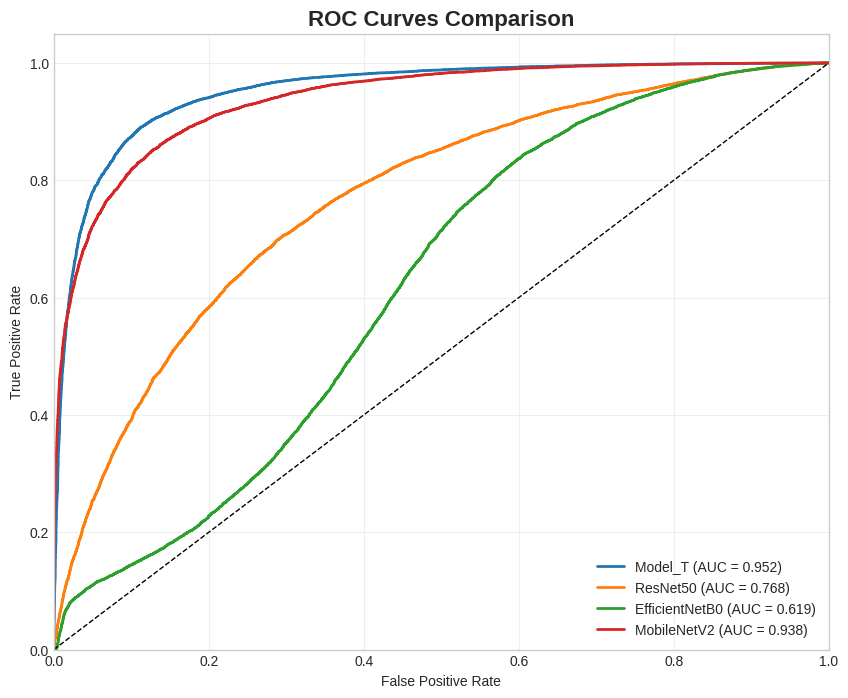

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for name, model in model_dict.items():
    # probability of prediction
    y_pred_proba = model.predict(test_generator)
    y_true = test_generator.labels

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # graph
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## 4-5. Final Performance Summary

In [46]:
summary_data = {
    'Model': list(results_df.index),
    'Test Accuracy': results_df['accuracy'].values,
    'Test AUC': results_df['auc'].values,
    'F1 Score': results_df['f1_score'].values
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test AUC', ascending=False)
print(summary_df.to_string(index=False))

# save best model
best_model_name = results_df['auc'].idxmax()
best_model = model_dict[best_model_name]
best_model.save(f'best_model_{best_model_name}.h5')

         Model  Test Accuracy  Test AUC  F1 Score
       Model_T         0.8880    0.9522    0.8582
   MobileNetV2         0.8645    0.9382    0.8246
      ResNet50         0.7103    0.7685    0.5929
EfficientNetB0         0.6140    0.6191    0.1368


# 5. Conclusion

* Results & Interpretation

 * For histopathological cancer detection, one model (Model T) was custom-designed based on the philosophy of ResNet, and it was compared against other well-known implemented models (ResNet50, EfficientNetB0, MobileNetV2).

   * Model T: Achieved the best performance with an AUC of 0.952, Accuracy of 88.8%, and an F1-score of 0.858.

   * MobileNetV2: Recorded the second-best performance with an AUC of 0.938, Accuracy of 86.5%, and an F1-score of 0.825.

   * ResNet50: Showed the third-best performance with an AUC of 0.768, Accuracy of 71.0%, and an F1-score of 0.593.

   * EfficientNetB0: Had the lowest performance with an AUC of 0.619, Accuracy of 61.4%, and an F1-score of 0.137.
 * The custom-designed Model T outperformed the transfer learning models, which suggests that its architecture, specialized for relatively small images, was effective.

 * It is presumed that the transfer learning models underperformed because their layers were frozen (as indicated by base_model.trainable = False), meaning their weights were not updated during the training process.

* Shortcomings

 * Systematic hyperparameter tuning was not performed due to GPU limitations (using a Colab A100) and time constraints.

 * The transfer learning strategy was simplistic, employing only layer freezing.

 * There was a class imbalance (Label 0: ~60%, Label 1: ~40%).

 * The architecture of Model T is a very simple, linear structure.

 * A fixed learning rate was used.

 * The BATCH_SIZE was quite large.

 * The data augmentation techniques were basic.

* Future Improvements

 * Model T currently uses a simple, linear structure built with Keras's Sequential API. By incorporating the Skip Connection concept from ResNet and increasing the model's depth by adding more blocks, it should be possible to reduce overfitting and improve performance.

 * The current learning rate is fixed at 0.001. Optimizing it with a learning rate scheduler, such as a Cosine Annealing Scheduler or Warm-up with Exponential Decay, could increase training speed and stability. Additionally, the current BATCH_SIZE of 512 is quite large; experimenting with a smaller BATCH_SIZE could lead to more stable training.

 * The current class distribution is ~60% normal (0) and ~40% cancer (1). In this imbalanced scenario, a model using Binary Cross-Entropy can be biased towards the majority class. To address this, introducing Focal Loss would be beneficial. Reducing False Negatives is critical in medical imaging, and Focal Loss can improve Recall by assigning a larger penalty to incorrect predictions of the minority (cancer) class.

 * Regarding Data Augmentation, applying techniques more specialized for medical imaging, such as shear_range or brightness_range, or employing advanced methods like MixUp and CutMix, could further enhance the quality of the training data.


# 6. Submission

In [50]:
submit_df = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))
test_images_path = os.path.join(BASE_PATH, 'test/')

submit_df['id'] = submit_df['id'].astype(str) + '.tif'

test_datagen = ImageDataGenerator(rescale=1./255)

submission_generator = test_datagen.flow_from_dataframe(
    submit_df,
    directory=test_images_path,
    x_col='id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# prediction
predictions = best_model.predict(submission_generator)

# 제출 파일 생성
submit_df['id'] = submit_df['id'].str.replace('.tif', '')
submit_df['label'] = predictions
submit_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 342ms/step


In [ ]:
from google.colab import files
files.download('submission.csv')

In [49]:
files.download(f'best_model_{best_model_name}.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. References

* "Korean-To-English Translation" prompt. Gemini, Google, 29 July 2025, https://g.co/gemini/share/cb552c641a81

# 8. Github

* https://github.com/mulkib/csca5642.git